# MLB Training Data
> Part 2 - Downloading the data and training the model with XGBoost

- toc: true
- badges: true
- comments: true
- categories: [baseball, webscraping, xgboost, brier, accuracy, calibration]
- image: images/chart-preview.png

This is the second post in my series on MLB Baseball Betting, and it's a long one. Here we're going to have a complete working model from scraping the data, processing it, adding features and finally giving it a run in XGBoost.

This is all done in a single notebook so you can start fiddling with it on your own as soon as you want. Use the buttons on the top to download your own copy from github or run it in the cloud on one of the services listed.

## Scrape Data
For this model, I'm going to use the stats from the [baseball-reference.com](http://baseball-reference.com) box scores page. [Here](https://www.baseball-reference.com/boxes/ANA/ANA202009190.shtml) is and example of the page we'll be scraping. Let's get started.

### Create List of Games to Download
We'll get the games from the schedule pages, creating a list of links to each game. Let's start in 2016, that should give us enough games to start making inferences.

In [4]:
import requests
from bs4 import BeautifulSoup as bs

game_links = []
for current_year in range(2016,2021):
    url = f"https://www.baseball-reference.com/leagues/MLB/{current_year}-schedule.shtml"
    resp = requests.get(url)
    soup=bs(resp.text)
    games = soup.findAll('a',text='Boxscore')
    game_links.extend([x['href'] for x in games])
print("Number of games to download: ", len(game_links))
game_links[0]

Number of games to download:  10641


'/boxes/KCA/KCA201604030.shtml'

### Download Game Data
For each game, I want to download team performance in batting and pitching, as well as individual performance pitching. For 10K games, this is going to take a little while to build out.

In [11]:
#collapse-hide

# these are functions related to parsing the baseball reference page

def get_game_summary(soup, game_id):
    game = {'game_id': game_id}
    scorebox = soup.find('div', {'class':'scorebox'})
    teams = scorebox.findAll('a',{'itemprop':'name'})
    game['away_team_abbr'] = teams[0]['href'].split('/')[2]
    game['home_team_abbr'] = teams[1]['href'].split('/')[2]
    meta = scorebox.find('div', {'class':'scorebox_meta'}).findAll('div')
    game['date'] = meta[0].text.strip()
    game['start_time'] = meta[1].text[12:-6].strip()
    return game

def get_table_summary(soup, table_no):
    stats_tables = soup.findAll('table', {'class':'stats_table'})
    t = stats_tables[table_no].find('tfoot')
    summary = {x['data-stat']:x.text.strip() for x in t.findAll('td')}
    return summary

def get_pitcher_data(soup, table_no):
    stats_tables = soup.findAll('table', {'class':'stats_table'})
    t = stats_tables[table_no]
    data = []
    rows = t.findAll('tr')[1:-1] # not the header and footer rows
    for r in rows:
        summary = {x['data-stat']:x.text.strip() for x in r.findAll('td')}
        summary['name'] = r.find('th',{'data-stat':'player'}).find('a')['href'].split('/')[-1][:-6].strip()
        data.append(summary)
    return data

def process_link(url):
    resp = requests.get(url)
    game_id = url.split('/')[-1][:-6]

    # strange preprocessing routine
    uncommented_html = ''
    for h in resp.text.split('\n'):
        if '<!--     <div' in h: continue
        if h.strip() == '<!--': continue
        if h.strip() == '-->': continue
        uncommented_html += h + '\n'

    soup = bs(uncommented_html)
    data = {
        'game': get_game_summary(soup, game_id),
        'away_batting': get_table_summary(soup, 1),
        'home_batting':get_table_summary(soup, 2),
        'away_pitching':get_table_summary(soup, 3),
        'home_pitching':get_table_summary(soup, 4),
        'away_pitchers': get_pitcher_data(soup, 3),
        'home_pitchers': get_pitcher_data(soup, 4)
    }
    return data

In [6]:
import datetime as dt
game_data = []
for link in game_links:
    url = 'https://www.baseball-reference.com' + link
    game_data.append(process_link(url))
    if len(game_data)%1000==0: print(dt.datetime.now().time(), len(game_data))

21:44:35.084156 1000
21:49:42.274916 2000
21:54:54.916589 3000
22:00:10.507164 4000
22:05:22.761320 5000
22:10:34.759694 6000
22:15:47.269227 7000
22:21:05.776663 8000
22:26:17.596819 9000
22:31:37.716245 10000


That took a while. We could definitely speed it up with threading, but we want to be nice to their servers. They seem like good people, making their data available to everyone.

Here is what a single game looks like. It's actually quite a bit of data.

In [7]:
game_data[0]

{'game': {'game_id': 'KCA201604030',
  'away_team_abbr': 'NYM',
  'home_team_abbr': 'KCR',
  'date': 'Sunday, April 3, 2016',
  'start_time': '7:38 p.m.'},
 'away_batting': {'AB': '33',
  'R': '3',
  'H': '7',
  'RBI': '3',
  'BB': '6',
  'SO': '9',
  'PA': '39',
  'batting_avg': '.212',
  'onbase_perc': '.333',
  'slugging_perc': '.242',
  'onbase_plus_slugging': '.576',
  'pitches': '177',
  'strikes_total': '105',
  'wpa_bat': '-0.449',
  'leverage_index_avg': '1.58',
  'wpa_bat_pos': '0.746',
  'wpa_bat_neg': '-1.195',
  're24_bat': '-1.7',
  'PO': '24',
  'A': '15',
  'details': ''},
 'home_batting': {'AB': '30',
  'R': '4',
  'H': '9',
  'RBI': '4',
  'BB': '2',
  'SO': '3',
  'PA': '33',
  'batting_avg': '.300',
  'onbase_perc': '.333',
  'slugging_perc': '.300',
  'onbase_plus_slugging': '.633',
  'pitches': '114',
  'strikes_total': '71',
  'wpa_bat': '0.052',
  'leverage_index_avg': '0.74',
  'wpa_bat_pos': '0.488',
  'wpa_bat_neg': '-0.434',
  're24_bat': '-0.1',
  'PO': '27

Let's save our work, so we don't have to do that download again.
> Important: We will be using the files saved in subsequent blog posts. Be sure to save them locally if you run this notebook online.

In [8]:
# save our work
import pickle
pickle.dump(game_data, open('game_data.pkl', 'wb'))

## Prep Data for Modelling
The idea behind the model is that we care about the difference in the stats for our two opposing teams. So if the home team starting pitcher usually gets a lot more strikeouts than the away team's pitcher, that's the number we want to feed the model. As you saw above, we're going to be doing this for several stats.
### Load data into DataFrames
The first task is to load our data into dataframes. We're going to end up with 4:
* **game_df**: This will be our main dataframe that will eventually get fed into the model
* **pitching_df**: This holds the pitching data, two rows per game (one for how team, one for away team). It's constructed this way because we need to be able to group our data per team.
* **batting_df**: Same as above but for batting stats.
* **pitcher_df**: This is the same as pitching_df, but has one row per player. We'll derive our starting pitcher stats from here.

First, let's load our saved work.

In [38]:
import pickle
game_data = pickle.load(open('game_data.pkl', 'rb'))

In [39]:
import pandas as pd

games = []
batting = []
pitching = []
pitchers = []

for g in game_data:
    game_summary = g['game']

    # fix date
    game_summary['date'] = game_summary['date'] + " " + game_summary['start_time']
    del game_summary['start_time']

    # get starting pitchers
    game_summary['home_pitcher'] = g['home_pitchers'][0]['name']
    game_summary['away_pitcher'] = g['away_pitchers'][0]['name']

    # this is the field we'll train our model to predict
    game_summary['home_team_win'] = int(g['home_batting']['R'])>int(g['away_batting']['R'])
    games.append(game_summary)

    target_pairs = [
        ('away_batting', batting),
        ('home_batting', batting),
        ('away_pitching', pitching),
        ('home_pitching', pitching),
        ('away_pitchers', pitchers),
        ('home_pitchers', pitchers)
    ]
    for key, d in target_pairs:
        if isinstance(g[key], list): # pitchers
            for x in g[key]:
                if 'home' in key:
                    x['is_home_team'] = True
                    x['team'] = g['game']['home_team_abbr']
                else:
                    x['is_home_team'] = False
                    x['team'] = g['game']['away_team_abbr']
                x['game_id'] = g['game']['game_id']
                d.append(x)
        else: #batting, pitching
            x = g[key]
            if 'home' in key:
                x['is_home_team'] = True
                x['team'] = g['game']['home_team_abbr']
            else:
                x['is_home_team'] = False
                x['team'] = g['game']['away_team_abbr']
            x['game_id'] = g['game']['game_id']
            d.append(x)
len(games), len(batting), len(pitching), len(pitchers)

(10641, 21282, 21282, 91664)

**Game DF**

This one is where we'll eventually put all of our stats

In [40]:
game_df = pd.DataFrame(games)
#TODO: fix games that were rescheduled which become NaT after this next command
game_df['date'] = pd.to_datetime(game_df['date'], errors='coerce')
game_df = game_df[~game_df['game_id'].str.contains('allstar')].copy() #don't care about allstar games
game_df.head()

,game_id,away_team_abbr,home_team_abbr,date,home_pitcher,away_pitcher,home_team_win
0,KCA201604030,NYM,KCR,2016-04-03 19:38:00,volqued01,harvema01,True
1,PIT201604030,STL,PIT,2016-04-03 13:15:00,liriafr01,wainwad01,True
2,TBA201604030,TOR,TBR,2016-04-03 16:09:00,archech01,stromma01,False
3,ANA201604040,CHC,LAA,2016-04-04 19:08:00,richaga01,arrieja01,False
4,ARI201604040,COL,ARI,2016-04-04 18:42:00,greinza01,rosajo01,False


**Batting DF**

Stats about batting, one row per team per game

In [41]:
batting_df = pd.DataFrame(batting)
for k in batting_df.keys():
    if any(x in k for x in ['team','game_id', 'home_away']): continue
    batting_df[k] =pd.to_numeric(batting_df[k],errors='coerce', downcast='float')
batting_df.drop(columns=['details'], inplace=True)
batting_df.head()

,AB,R,H,RBI,BB,SO,PA,batting_avg,onbase_perc,slugging_perc,...,wpa_bat,leverage_index_avg,wpa_bat_pos,wpa_bat_neg,re24_bat,PO,A,is_home_team,team,game_id
0,33.0,3.0,7.0,3.0,6.0,9.0,39.0,0.212,0.333,0.242,...,-0.449,1.58,0.746,-1.195,-1.7,24.0,15.0,False,NYM,KCA201604030
1,30.0,4.0,9.0,4.0,2.0,3.0,33.0,0.300,0.333,0.300,...,0.052,0.74,0.488,-0.434,-0.1,27.0,13.0,True,KCR,KCA201604030
2,32.0,1.0,5.0,1.0,5.0,14.0,38.0,0.156,0.289,0.156,...,-0.431,1.27,0.504,-0.935,-3.4,24.0,11.0,False,STL,PIT201604030
3,28.0,4.0,9.0,4.0,5.0,5.0,36.0,0.321,0.429,0.464,...,0.070,0.71,0.466,-0.394,0.1,27.0,8.0,True,PIT,PIT201604030
4,35.0,5.0,7.0,5.0,3.0,16.0,38.0,0.200,0.263,0.314,...,0.134,0.76,0.558,-0.423,0.7,27.0,15.0,False,TOR,TBA201604030


**Pitching DF**

Team pitching stats, one row per team per game

In [42]:
pitching_df = pd.DataFrame(pitching)
for k in pitching_df.keys():
    if any(x in k for x in ['team','game_id', 'home_away']): continue
    pitching_df[k] =pd.to_numeric(pitching_df[k],errors='coerce', downcast='float')
pitching_df.head()

,IP,H,R,ER,BB,SO,HR,earned_run_avg,batters_faced,pitches,...,inplay_unk,game_score,inherited_runners,inherited_score,wpa_def,leverage_index_avg,re24_def,is_home_team,team,game_id
0,8.0,9.0,4.0,3.0,2.0,3.0,0.0,3.38,33.0,114.0,...,0.0,39.0,2.0,1.0,-0.051,0.74,0.1,False,NYM,KCA201604030
1,9.0,7.0,3.0,3.0,6.0,9.0,0.0,3.00,39.0,177.0,...,0.0,70.0,2.0,0.0,0.449,1.58,1.7,True,KCR,KCA201604030
2,8.0,9.0,4.0,4.0,5.0,5.0,0.0,4.50,36.0,144.0,...,0.0,48.0,0.0,0.0,-0.069,0.71,-0.1,False,STL,PIT201604030
3,9.0,5.0,1.0,1.0,5.0,14.0,0.0,1.00,38.0,141.0,...,0.0,71.0,0.0,0.0,0.431,1.27,3.4,True,PIT,PIT201604030
4,9.0,7.0,3.0,3.0,1.0,7.0,1.0,3.00,36.0,118.0,...,0.0,62.0,1.0,1.0,0.366,0.98,1.3,False,TOR,TBA201604030


**Pitcher DF**

Individual pitching stats (starting pitchers only), one row per pitcher per game

In [43]:
pitcher_df = pd.DataFrame(pitchers)
for k in pitcher_df.keys():
    if any(x in k for x in ['team','name','game_id', 'home_away']): continue
    pitcher_df[k] =pd.to_numeric(pitcher_df[k],errors='coerce', downcast='float')
# filter the pitcher performances to just the starting pitcher
pitcher_df = pitcher_df[~pitcher_df['game_score'].isna()].copy().reset_index(drop=True)
pitcher_df.drop(columns=[x for x in pitcher_df.keys() if 'inherited' in x], inplace=True)
pitcher_df.head()

,IP,H,R,ER,BB,SO,HR,earned_run_avg,batters_faced,pitches,...,inplay_ld,inplay_unk,game_score,wpa_def,leverage_index_avg,re24_def,name,is_home_team,team,game_id
0,5.2,8.0,4.0,3.0,2.0,2.0,0.0,4.76,25.0,83.0,...,5.0,0.0,39.0,-0.061,0.86,-0.4,harvema01,False,NYM,KCA201604030
1,6.0,2.0,0.0,0.0,3.0,5.0,0.0,0.00,22.0,106.0,...,2.0,0.0,70.0,0.350,0.92,3.1,volqued01,True,KCR,KCA201604030
2,6.0,6.0,3.0,3.0,3.0,3.0,0.0,4.50,26.0,96.0,...,6.0,0.0,48.0,-0.069,0.90,-0.1,wainwad01,False,STL,PIT201604030
3,6.0,3.0,0.0,0.0,5.0,10.0,0.0,0.00,26.0,94.0,...,0.0,0.0,71.0,0.329,1.52,2.9,liriafr01,True,PIT,PIT201604030
4,8.0,6.0,3.0,3.0,1.0,5.0,1.0,3.38,32.0,98.0,...,5.0,0.0,62.0,0.282,0.92,1.5,stromma01,False,TOR,TBA201604030


### Calculate Differences in the Statistics
Here is where we're going to generate a bunch of columns in the game_df. Our statistical differences are going to be calculated like this:
```
For every downloaded statistic:
    calculate the average, standard deviation and skew:
        for time periods of 5, 10, 45, 180 and 730 days:
            grouped by team (or pitcher name in the case of pitchers)
    then shift the data so each row contains pre-game statistics
    then take the difference of the opposing team
```
That result is put into the game_df with a name like "5day_R_Avg", or "45Day_IP_StDev". The other dfs are done at that point.

Below are the routines to help execute the above algorithm.


In [44]:
import numpy as np

def add_rolling(period, df, stat_columns):
    for s in stat_columns:
        if 'object' in str(df[s].dtype): continue
        df[s+'_'+str(period)+'_Avg'] = df.groupby('team')[s].apply(lambda x:x.rolling(period).mean())
        df[s+'_'+str(period)+'_Std'] = df.groupby('team')[s].apply(lambda x:x.rolling(period).std())
        df[s+'_'+str(period)+'_Skew'] = df.groupby('team')[s].apply(lambda x:x.rolling(period).skew())
    return df

def get_diff_df(df, name, is_pitcher=False):
    #runs for each of the stat dataframes, returns the difference in stats

    #set up dataframe with time index
    df['date'] = pd.to_datetime(df['game_id'].str[3:-1], format="%Y%m%d")
    df = df.sort_values(by='date').copy()
    newindex = df.groupby('date')['date']\
             .apply(lambda x: x + np.arange(x.size).astype(np.timedelta64))
    df = df.set_index(newindex).sort_index()

    # get stat columns
    stat_cols = [x for x in df.columns if 'int' in str(df[x].dtype)]
    stat_cols.extend([x for x in df.columns if 'float' in str(df[x].dtype)])

    #add lags
    df = add_rolling('5d', df, stat_cols) # this game series
    df = add_rolling('10d', df, stat_cols)
    df = add_rolling('45d', df, stat_cols)
    df = add_rolling('180d', df, stat_cols) # this season
    df = add_rolling('730d', df, stat_cols) # 2 years

    # reset stat columns to just the lags (removing the original stats)
    df.drop(columns=stat_cols, inplace=True)
    stat_cols = [x for x in df.columns if 'int' in str(df[x].dtype)]
    stat_cols.extend([x for x in df.columns if 'float' in str(df[x].dtype)])

    # shift results so that each row is  a pregame stat
    df = df.reset_index(drop=True)
    df = df.sort_values(by='date')
    for s in stat_cols:
        if is_pitcher:
            df[s] = df.groupby('name')[s].shift(1)
        else:
            df[s] = df.groupby('team')[s].shift(1)

    # calculate differences in pregame stats from home vs. away teams
    away_df = df[~df['is_home_team']].copy()
    away_df = away_df.set_index('game_id')
    away_df = away_df[stat_cols]

    home_df = df[df['is_home_team']].copy()
    home_df = home_df.set_index('game_id')
    home_df = home_df[stat_cols]

    diff_df = home_df.subtract(away_df, fill_value=0)
    diff_df = diff_df.reset_index()

    # clean column names
    for s in stat_cols:
        diff_df[name + "_" + s] = diff_df[s]
        diff_df.drop(columns=s, inplace=True)

    return diff_df

Below calculates the differences for each datafraame of stats, then merges those differences back into the main df.

In [45]:
df = game_df

df = pd.merge(left=df, right = get_diff_df(batting_df, 'batting'),
               on = 'game_id', how='left')
print(df.shape)

df = pd.merge(left=df, right = get_diff_df(pitching_df, 'pitching'),
               on = 'game_id', how='left')
print(df.shape)

df = pd.merge(left=df, right = get_diff_df(pitcher_df, 'pitcher',is_pitcher=True),
               on = 'game_id', how='left')
df.shape

(10641, 307)
(10641, 667)


(10641, 997)

Below we add some datetime features, as I generally do with time-series data like this.

In [46]:
df.dropna(subset=['date'], inplace=True)
df['season'] = df['date'].dt.year
df['month']=df['date'].dt.month
df['dow']=df['date'].dt.weekday
df['date'] = (pd.to_datetime(df['date']) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s') #epoch time


Save our work

In [47]:
import pickle
pickle.dump(df, open('dataframe.pkl', 'wb'))

## Train the Model
Finally, we get to train the model! This is just going to be a crude first run to make sure everything is working properly. We'll add the cleverest bits in the next blog post.

First, load our saved saved work

In [48]:
import pickle
df = pickle.load(open('dataframe.pkl', 'rb'))


Target encoding for remaining string features. This will effectively create a 180-day win% value in each of the team name columns.

In [49]:
encode_me = [x for x in df.keys() if 'object' in str(df[x].dtype)]
for x in encode_me:
    df[x] = df.groupby(x)['home_team_win'].apply(lambda x:x.rolling(180).mean()).shift(1)


Create our test, train and validate data sets

In [50]:
df = df.sort_values(by='date').copy().reset_index(drop=True)
X = df.drop(columns=['home_team_win', 'game_id'])
y = df.home_team_win

X_train = X[:-1000]
y_train = y[:-1000]
X_valid = X[-1000:-500]
y_valid = y[-1000:-500]
X_test = X[-500:]
y_test = y[-500:]

Here's the training bit

In [51]:
import xgboost as xgb
params = {'learning_rate': 0.075,'max_depth': 2}
gbm = xgb.XGBClassifier(**params)
model = gbm.fit(X_train, y_train,
                eval_set = [[X_train, y_train],
                          [X_valid, y_valid]],
                eval_metric='logloss',
                early_stopping_rounds=10)
xgb_test_preds = model.predict(X_test)
xgb_test_proba = model.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.69101	validation_1-logloss:0.69157
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.68916	validation_1-logloss:0.69014
[2]	validation_0-logloss:0.68753	validation_1-logloss:0.68861
[3]	validation_0-logloss:0.68608	validation_1-logloss:0.68769
[4]	validation_0-logloss:0.68467	validation_1-logloss:0.68612
[5]	validation_0-logloss:0.68343	validation_1-logloss:0.68522
[6]	validation_0-logloss:0.68224	validation_1-logloss:0.68437
[7]	validation_0-logloss:0.68121	validation_1-logloss:0.68320
[8]	validation_0-logloss:0.68024	validation_1-logloss:0.68275
[9]	validation_0-logloss:0.67937	validation_1-logloss:0.68241
[10]	validation_0-logloss:0.67856	validation_1-logloss:0.68224
[11]	validation_0-logloss:0.67783	validation_1-logloss:0.68179
[12]	validation_0-logloss:0.67713	validation_1-logloss:0.68142
[13]	validation_0-logloss:

And our results...

Casino		Accuracy:0.6006	 Brier Loss: 0.2358
XGBoost		Accuracy:0.5680	 Brier Loss: 0.2405


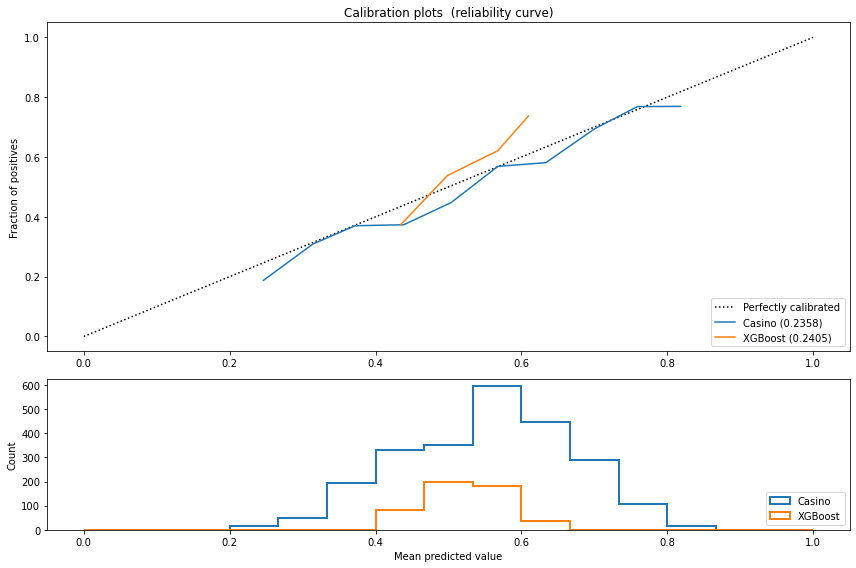

In [52]:
#collapse-hide
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score, brier_score_loss
import matplotlib.pyplot as plt
import pickle

def cal_curve(data, bins):
    # adapted from:
    #https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html
    fig = plt.figure(1, figsize=(12, 8))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for y_test, y_pred, y_proba, name in data:
        brier = brier_score_loss(y_test, y_proba)
        print("{}\t\tAccuracy:{:.4f}\t Brier Loss: {:.4f}".format(
            name, accuracy_score(y_test, y_pred), brier))
        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, y_proba, n_bins=bins)
        ax1.plot(mean_predicted_value, fraction_of_positives,
                 label="%s (%1.4f)" % (name, brier))
        ax2.hist(y_proba, range=(0, 1), bins=bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

outcomes,predictions,probabilities = pickle.load(open('baseline.pkl','rb'))
data = [
    (outcomes, predictions, probabilities, 'Casino'),
    (y_test,xgb_test_preds, xgb_test_proba, 'XGBoost')
]
cal_curve(data, 15)

That's not terrible for a first run - ~57% accuracy for our model vs. 60% for the casinos. We're only off by 3% and we still have our secret features and model optimization to do.

Our calibration is also worse, but again it's not at all terrible for our first run. I like to think of it in terms of [forecasting skill](https://en.wikipedia.org/wiki/Forecast_skill). Our calibration skill is 2.0% worse than the casino's, as measured by our brier loss function.

This model has some promise. Let's look at the feature importances just to see which features it's using most. It looks like the model likes [RE24](https://thebaseballscholar.com/2017/08/14/sabermetrics-101-re24/), and it likes the longer lags: 180day & 730day.

<AxesSubplot:title={'center':'XGBoost Feature Gain'}>

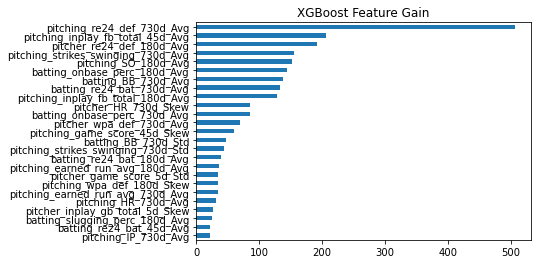

In [53]:
#collapse-hide
import pandas as pd
x = pd.Series(model.get_booster().get_score(importance_type= 'total_gain')
         ).sort_values()
x[-25:].plot(kind='barh',title="XGBoost Feature Gain")

## Next Up
In Part 3, we're going to add team power rankings and casino odds to the dataset to improve the results further!